In [2]:
%matplotlib inline
import sys
import sklearn
from scipy import ndimage
### from skimage import color
from sklearn import decomposition
from common.show import *
from common.image import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.display import clear_output

In [31]:
train_range = 30000
query_range = 100

In [32]:

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_image(imglist, c='gray', vmin=0, vmax=1, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 60 # pyplot default?
    fig = plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        if needs_encoding:
            img = gamma_encode(img)
        plt.subplot(1,n,i + 1)
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.tight_layout()
        fig = plt.imshow(img, interpolation='bilinear')

def show_images(imglist, indices=None, needs_encoding=False, zoom=1.5):
    if indices is not None:
        imglist = [imglist[i] for i in indices]
    if type(imglist) is not list:
       imglist = [imglist]
    # print(list(imglist))
    merged = np.hstack(imglist)
    if len(merged.shape) == 2:
        merged = np.repeat(merged[:,:,np.newaxis],3,2)
    # print("merged: " + str(merged.shape))
    dpi = 77.0
    plt.figure(figsize=(merged.shape[0]*zoom/dpi,merged.shape[1]*zoom/dpi))
    plt.axis('off')
    plt.tight_layout()
    if needs_encoding:
        merged = gamma_encode(merged)
    plt.imshow(merged, interpolation='bilinear')

30000/30000


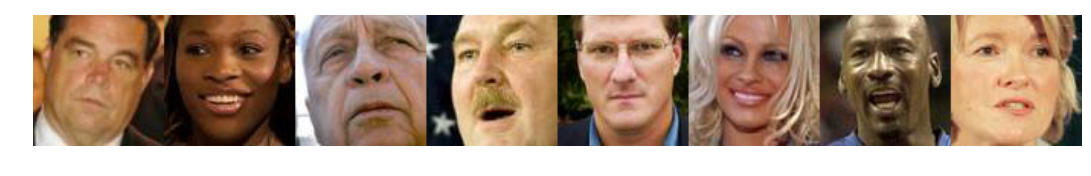

In [33]:
train_images = []
train_descrip = []
for i in range(1,train_range+1):
    img = scipy.ndimage.imread("data/faces/trainset/%d.jpg" % i)/255
    small = scipy.misc.imresize(img,(32,32))/255
    big = scipy.misc.imresize(img,(86,86))/255
    train_images.append(big)
    desc = rgb2Y(small).flatten()
    train_descrip.append(desc)
    if i % 1000 == 0:
        clear_output()
        print("%d/%d" % (i, train_range))
        
show_images(train_images,[42,150,230,320,0,1,2,3], zoom=10)

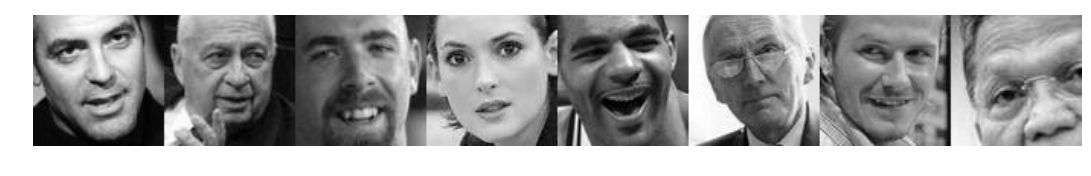

In [34]:
queries = []
for i in range(1,query_range+1):
    img = scipy.ndimage.imread("data/faces/testset/%d.jpg" % i)/255
    img = scipy.misc.imresize(img,(86,86))/255
    queries.append(img)

show_images(queries,[0,1,2,3,4,5,6,7], zoom=10)

In [35]:
def perform_query(q, k=10):
    desc = scipy.misc.imresize(q,(32,32)).flatten()/255
    diffs = np.abs(train_descrip - desc).sum(axis=1)
    # !!! Linear!
    ind = np.argpartition(diffs, k)[:k]
    # ind = ind[np.argsort(diffs[ind])]
    
    # ind = np.argsort(diffs)[0:k]
    return ind, desc
    
def colorize(query, k=32, intermediate_results=False, query_func=perform_query):
    indices, descrip = query_func(query, k)
    neighboors = np.array([train_images[i] for i in indices])
    avgneigh = neighboors.mean(axis=0)
    
    _, Cb,Cr = split_to_YCbCr(avgneigh)
    combined = merge_from_YCbCr(query,Cb,Cr)
    
    if intermediate_results:
        return indices, avgneigh, combined
    else:
        return combined

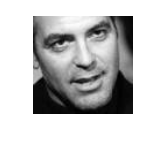

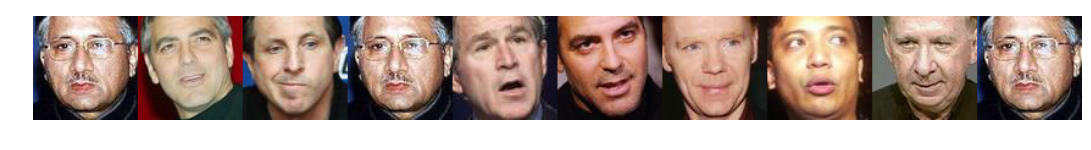

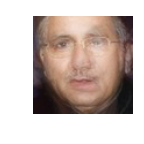

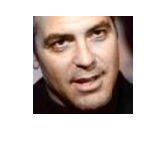

In [39]:
test_query = 0

indices, avgneigh, combined = colorize(queries[test_query], 10, intermediate_results=True)
show_images(queries[test_query], zoom=1.5)
show_images(train_images, indices, zoom=10)
show_images(avgneigh, zoom=1.5)
show_images(combined, zoom=1.5)

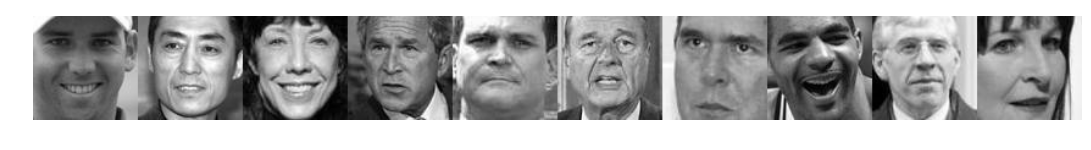

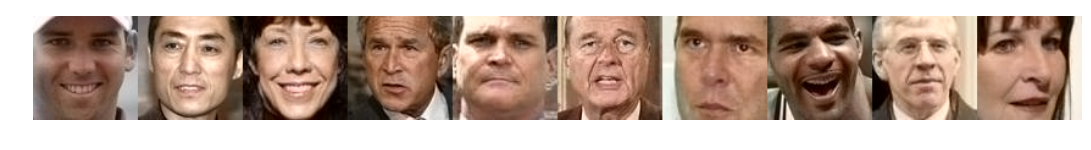

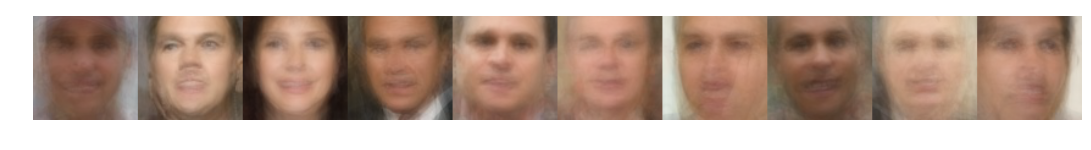

In [41]:
def mass_query(queries, k, query_func=perform_query):
    return [colorize(query, k, intermediate_results=False, query_func=query_func) for query in queries]
def mass_query_intermediate(queries, k, query_func=perform_query):
    avgneighs = []
    results = []
    for query in queries:
        _, avg, res = colorize(query, k, intermediate_results=True, query_func=query_func)
        avgneighs.append(avg)
        results.append(res)
    return avgneighs, results
    
qid = np.random.choice(query_range, (10), replace=False)
query_images = [queries[i] for i in qid]
show_images(query_images, zoom=10)
avgneighs, results = mass_query_intermediate(query_images,32)
show_images(results, zoom=10)
show_images(avgneighs, zoom=10)

In [42]:
## PCA

descrip_matrix = np.array(train_descrip)
print(descrip_matrix.shape)

pca = sklearn.decomposition.PCA(n_components=19)
pca.fit(descrip_matrix)
reduced_matrix = pca.transform(descrip_matrix)
print(reduced_matrix.shape)

(30000, 1024)
(30000, 19)


In [63]:
def perform_query_pca(q, k=10):
    desc = scipy.misc.imresize(q,(32,32)).flatten()/255
    desc = pca.transform(desc.reshape(1,-1))
    diffs = np.abs(reduced_matrix - desc).sum(axis=1)
    # !!! Linear!
    ind = np.argpartition(diffs, k)[:k]
    return ind, desc


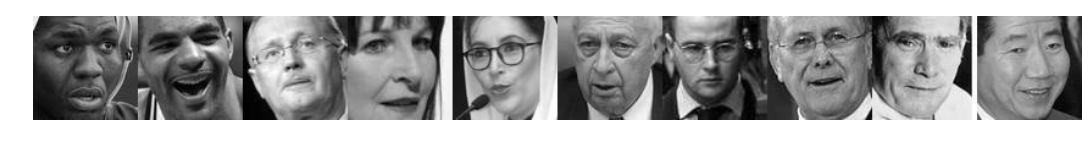

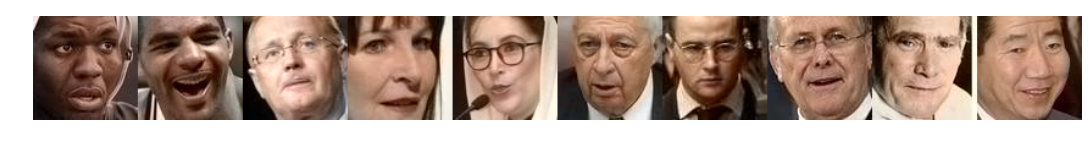

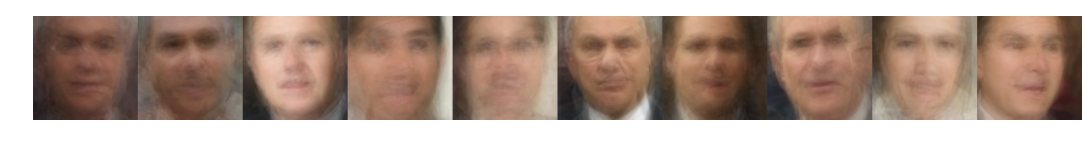

In [44]:
qid = np.random.choice(query_range, (10), replace=False)
query_images = [queries[i] for i in qid]
show_images(query_images, zoom=10)
avgneighs, results = mass_query_intermediate(query_images,32, query_func=perform_query_pca)
show_images(results, zoom=10)
show_images(avgneighs, zoom=10)

In [61]:
def test_query_time(query_func, n=1000):
    qid = np.random.choice(query_range, (n), replace=True)
    query_images = [queries[i] for i in qid]
    results = mass_query(query_images,32, query_func=query_func)
    return results

In [68]:
%time res = test_query_time(perform_query, 100)
print(len(res))

CPU times: user 10.2 s, sys: 30 s, total: 40.3 s
Wall time: 40.3 s
100


In [69]:
%time res = test_query_time(perform_query_pca, 100)
print(len(res))

CPU times: user 544 ms, sys: 0 ns, total: 544 ms
Wall time: 543 ms
100
